# CNN Skin Cancer Classification

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib


import numpy as np
import pandas as pd

import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from glob import glob

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Importing Skin Cancer Data
#### Necessary actions to read the data from the google drive, as the code is written using google colab

In [2]:
# Mounting the google drive to read the image data
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/colab_dataset/'

Mounted at /content/gdrive


#### Paths for train and test images

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
data_dir_test = pathlib.Path('gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

#### Verifying the test train image count

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

#### Path list of all the train images , required to populate the dataframe

In [5]:
# getting the exact paths of each image in train data folder
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(path_list)

['gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030463.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027580.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026212.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026575.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030344.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging

#### List of skin cancer classnames

In [6]:
# getting the classes of each image dataset based on the folder name as per the skin cancer name
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*', '*.jpg'))]
print(lesion_list)

['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

In [7]:
# creating a dictionary to prepare a dataframe
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [8]:
original_df.head()

,Path,Label
0,gdrive/My Drive/colab_dataset/CNN_assignment/S...,actinic keratosis
1,gdrive/My Drive/colab_dataset/CNN_assignment/S...,actinic keratosis
2,gdrive/My Drive/colab_dataset/CNN_assignment/S...,actinic keratosis
3,gdrive/My Drive/colab_dataset/CNN_assignment/S...,actinic keratosis
4,gdrive/My Drive/colab_dataset/CNN_assignment/S...,actinic keratosis


In [9]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

### Train Dataset

In [12]:
## getting the train dataset here using the keras library, with seed = 123, validation split = 20%, and image resize to 180x180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Validation Dataset

In [13]:
## getting the validation dataset here using the keras library with same setting as above
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [14]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data
#### Visualizing one instance of all the nine classes present in the dataset

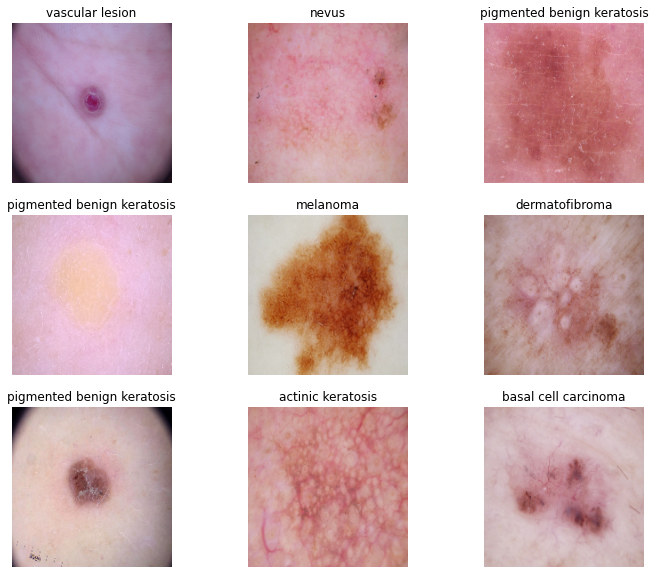

In [ ]:
# Plot the graph to visualize the images from each of the 9 classes
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model I : Simple model

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. Hence, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# Buildinf a sequential model with  rescaling and 3 conv layers and 2 dense layers with softmax as output activation
model = Sequential([
    # rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
     # maxpooling layer
  layers.MaxPooling2D(),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output dense layer
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Compiling the model using adam optimiser and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 22, 22, 64)       

### Train the model

In [ ]:
# training  the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 72ms/step - loss: 2.0345 - accuracy: 0.2556 - val_loss: 1.8869 - val_accuracy: 0.3154
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8145 - accuracy: 0.3309 - val_loss: 1.8117 - val_accuracy: 0.3557
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6569 - accuracy: 0.4224 - val_loss: 1.4799 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4150 - accuracy: 0.5095 - val_loss: 1.4601 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2832 - accuracy: 0.5402 - val_loss: 1.3752 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1767 - accuracy: 0.5848 - val_loss: 1.3649 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1272 - accuracy: 0.6049 - val_loss: 1.3280 - val_accuracy: 0.5145
Epoch 8/20
5

### Visualizing training results

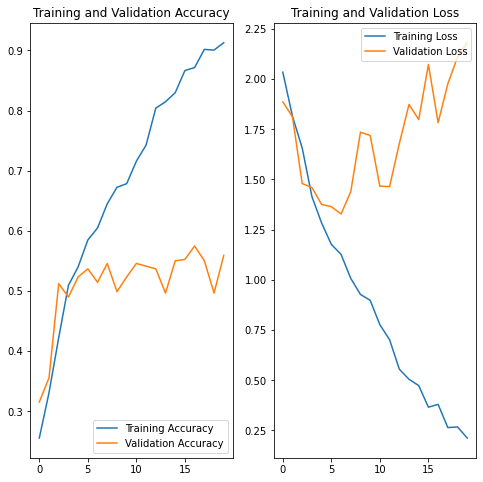

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from the graph and model history

#### Cleraly we can see that the model is overfitting the train accuracy is 91% and the validation accuracy is only 56%
#### One of the reasons of overfitting could be lack of sufficient images as we know that CNN model require huge amount of images to learn, hence it looks like the model is memorizing the train images and therefore leading to overfitting

### Data Augmentation

In [ ]:
# To handle the overfitting scenario above we can add some dynamic data augmenttaion like 
# - Random flipping
# - Random rotaion
# - Random zoom

# this data augmentation layer will prevent the model from memorizing the train data and hence we can handle overfiting

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)
])


### Visualize Augmented Data

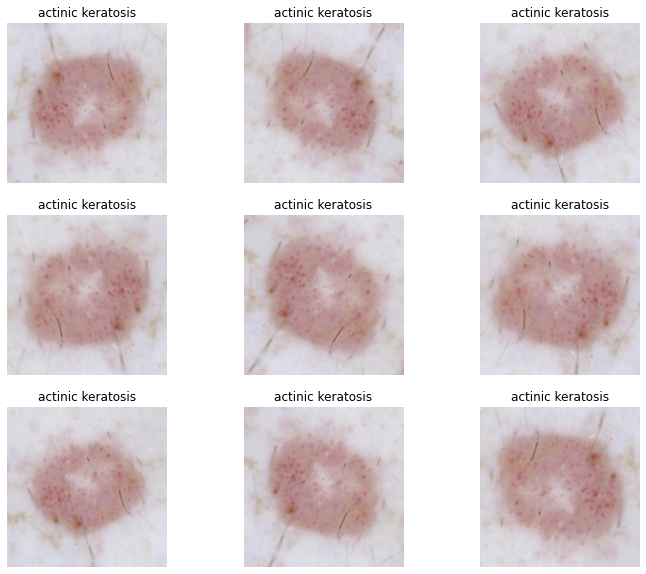

In [ ]:
# Plot graph to visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(num_classes):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
plt.show()

## Model II with Data augmentation layer

### Create the model, compile and train the model

In [ ]:
# Buildinf a sequential model with  data augmentation, rescaling and 3 conv layers and 2 dense layers with softmax as output activation
model = Sequential([
    # data augmentation layer
  data_augmentation,
    # Rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpoolig layer
  layers.MaxPooling2D(),
    # 2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # 3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [ ]:
## compiling the model with adam optimizer and sparse_categorical_crossentropy as loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 45, 45, 64)       

### Training the model

In [ ]:
## training the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 25ms/step - loss: 1.8998 - accuracy: 0.3147 - val_loss: 1.6400 - val_accuracy: 0.4385
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5390 - accuracy: 0.4559 - val_loss: 1.4791 - val_accuracy: 0.5034
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4843 - accuracy: 0.4704 - val_loss: 1.4690 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4054 - accuracy: 0.5050 - val_loss: 1.5146 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3666 - accuracy: 0.5179 - val_loss: 1.4329 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2885 - accuracy: 0.5396 - val_loss: 1.3961 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2596 - accuracy: 0.5519 - val_loss: 1.4474 - val_accuracy: 0.5190
Epoch 8/20
56

### Visualizing the results

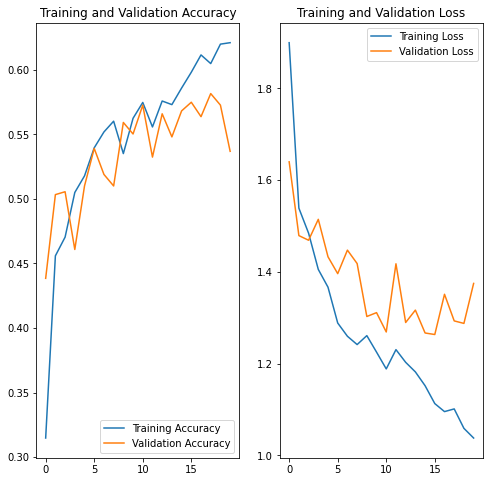

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings

#### There has been a considerable improvement now as compared to the previous model as we can see from the train and validation accuracy that the model overfitting has been handled, but the model performance is not so good only 62% train and 53% validation accuracy
#### One reason could be class imbalance

#### Lets find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Plotting graph to detect class imbalance

In [16]:
# creating the dictionary and dataframe of original train data to plot a bar graph to check the class imbalance
image_dict = {}
for classname in class_names:
    image_dict[classname] = len(list(data_dir_train.glob(classname+'/*.jpg')))   
print(image_dict)  

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [17]:
# creating dataframe containing count of images per class
df = pd.DataFrame()
counts = list(image_dict.values())
df['class'] = class_names
df['count'] = counts

In [18]:
df.head(10)

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


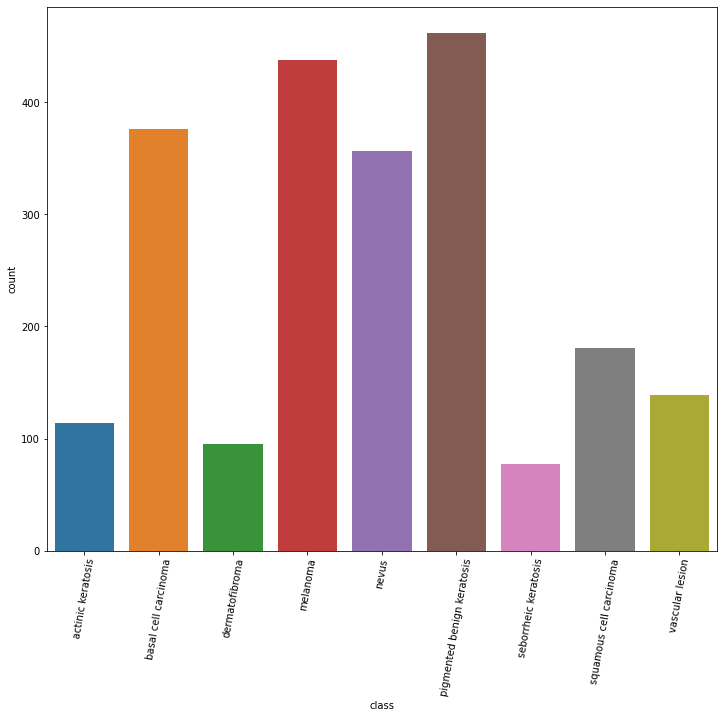

In [ ]:
# Plotting the bar graph for each class
plt.figure(figsize=(12, 10))
sns.barplot(x = df['class'], y = df['count'], data = df)
plt.xticks(rotation=80)
plt.show()

### Findings 

#### Clearly from above graph we can see that there is a class imbalance issue and the images are not uniformly distributed
#### - seborrheic keratosis  class has the least number of samples, that is 77
#### - pigmented benign keratosis, melanoma and basal cell carcinoma are the top 3 dominant classes wrt the sample count


#### To Rectify class imbalance we can use the Augmentor library to add more images to the existing samples which can help to resolve the class imbalance issue.
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset='gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
#data_dir_train = pathlib.Path('gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
## We are adding 500 samples per class to make sure that none of the classes are sparse.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C68DD9E90>:   0%|          | 1/500 [00:00<01:22,  6.06 Samples/s]

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C68DA7B90>: 100%|██████████| 500/500 [00:18<00:00, 26.62 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C68DA0410>:   0%|          | 1/500 [00:00<01:13,  6.75 Samples/s]

Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C68E892D0>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C1E03BE10>: 100%|██████████| 500/500 [00:20<00:00, 24.93 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1C1E25ED90>: 100%|██████████| 500/500 [01:38<00:00,  5.07 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C1E1019D0>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C0A517B90>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1C68E17150>: 100%|██████████| 500/500 [00:41<00:00, 11.93 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1C0A1CA550>:   0%|          | 2/500 [00:00<00:27, 18.15 Samples/s]

Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1CB4D3DC50>: 100%|██████████| 500/500 [00:19<00:00, 25.79 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1C0A25BFD0>: 100%|██████████| 500/500 [00:19<00:00, 25.78 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
# sum of sample images added in each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [20]:
# new path list of newly added sample images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(path_list_new)

['gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_86a9ab99-9a0e-4812-9499-8eb18e750e80.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_f3ceed8d-64dc-4a32-a0c6-d12f5c75b88f.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026702.jpg_f5aaf118-7020-48ec-8b76-daa8f0b2bbf5.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030242.jpg_45d622e6-99ef-4e63-b90d-e13a8e7b6b1d.jpg', 'gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging C

In [21]:
# class list of the added samples
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(lesion_list_new)

['actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic keratosis', 'actinic ker

In [24]:
# creating new dataframe with the newly added sample images and then merging with the existing original dataframe
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [25]:
# Lets check the final count of sample images in each class
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Now: Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset with the old samples and newly added samples 

In [ ]:
# getting the trainig dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [ ]:
# getting the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# checking the class names
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model III with added samples using Augmentor library

### Creating the model 

In [ ]:
# creating the sequential model with rescaling, 3 conv, 3 maxpooling, 3 dropouts and 2 dense layers
model = Sequential([
    # rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer with softmax
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model

In [ ]:
# compiling the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 45, 45, 32)      

### Training the model

In [ ]:
# trainig the model with 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 4s 22ms/step - loss: 2.3895 - accuracy: 0.1335 - val_loss: 2.1856 - val_accuracy: 0.1381
Epoch 2/30
169/169 [==============================] - 4s 21ms/step - loss: 2.1768 - accuracy: 0.1428 - val_loss: 2.1834 - val_accuracy: 0.1321
Epoch 3/30
169/169 [==============================] - 4s 21ms/step - loss: 2.0021 - accuracy: 0.2476 - val_loss: 1.8919 - val_accuracy: 0.2687
Epoch 4/30
169/169 [==============================] - 4s 22ms/step - loss: 1.6976 - accuracy: 0.3529 - val_loss: 1.5829 - val_accuracy: 0.4009
Epoch 5/30
169/169 [==============================] - 4s 22ms/step - loss: 1.4980 - accuracy: 0.4271 - val_loss: 1.5778 - val_accuracy: 0.3994
Epoch 6/30
169/169 [==============================] - 4s 22ms/step - loss: 1.3523 - accuracy: 0.4872 - val_loss: 1.3100 - val_accuracy: 0.5226
Epoch 7/30
169/169 [==============================] - 4s 22ms/step - loss: 1.2600 - accuracy: 0.5263 - val_loss: 1.2192 - val_accuracy: 0.5471

### Visualizing the model results

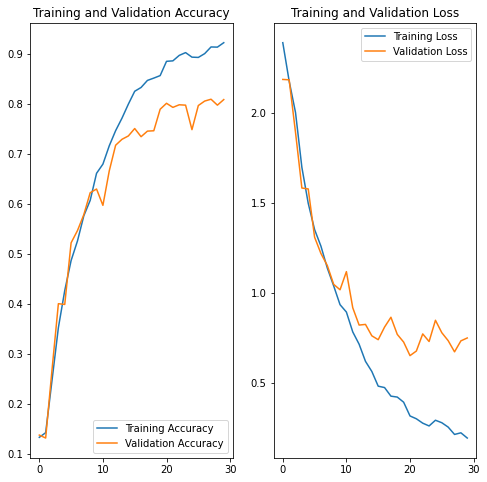

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings

#### Finally we could handle both overfitting and class imbalance issue and the model performance has increased considerably. 
#### train accuracy 92% and validation accuracy 81%

